<a href="https://colab.research.google.com/github/AlexKorshun/Attendance-Automation/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №1

Получение данных о домах и их стоимости

In [ ]:
import torch
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Загрузка данных California Housing
data = fetch_california_housing()
X, y = data.data, data.target  # X - признаки, y - цены домов

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Признаки о домах')
print(pd.DataFrame(X_train))
print('Целевое значение- которое хотим предсказать')
print(pd.DataFrame(y_train))

Признаки о домах
            0     1         2         3       4         5      6       7
0      3.2596  33.0  5.017657  1.006421  2300.0  3.691814  32.71 -117.03
1      3.8125  49.0  4.473545  1.041005  1314.0  1.738095  33.77 -118.16
2      4.1563   4.0  5.645833  0.985119   915.0  2.723214  34.66 -120.48
3      1.9425  36.0  4.002817  1.033803  1418.0  3.994366  32.69 -117.11
4      3.5542  43.0  6.268421  1.134211   874.0  2.300000  36.78 -119.80
...       ...   ...       ...       ...     ...       ...    ...     ...
16507  6.3700  35.0  6.129032  0.926267   658.0  3.032258  33.78 -117.96
16508  3.0500  33.0  6.868597  1.269488  1753.0  3.904232  34.02 -117.43
16509  2.9344  36.0  3.986717  1.079696  1756.0  3.332068  34.03 -118.38
16510  5.7192  15.0  6.395349  1.067979  1777.0  3.178891  37.58 -121.96
16511  2.5755  52.0  3.402576  1.058776  2619.0  2.108696  37.77 -122.42

[16512 rows x 8 columns]
Целевое значение- которое хотим предсказать
           0
0      1.030
1      3.82

In [ ]:
# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Преобразуем в колонку
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# **Создание DataLoader**


# Зачем нужен DataLoader?
**Управление данными**
Вместо того чтобы вручную загружать данные, обрабатывать их, формировать батчи и подавать их модели, DataLoader автоматизирует эти процессы.

**Разбиение на батчи (мини-пакеты)**
Данные часто обрабатываются небольшими порциями (батчами), чтобы ускорить вычисления и использовать возможности графических процессоров (GPU).
Например, если у нас есть 60,000 изображений, DataLoader может автоматически разбить их на батчи по 64.

**Перемешивание данных (shuffling)**
При обучении модели важно, чтобы данные в каждом эпизоде подавались в случайном порядке. Это помогает модели лучше обобщать знания.

**Многопоточная загрузка (дополнительная скорость)**
При работе с большими наборами данных загрузка может быть узким местом. DataLoader поддерживает многопоточность, что ускоряет загрузку.

**Простота использования**
DataLoader предоставляет интерфейс, с помощью которого можно легко итерироваться по данным в обучении, тестировании и валидации.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=16, shuffle=False)

# **Создание модели**

На вход модели будет подаваться 8 признаков, на выход мы ожидаем 1 значение.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        # Первый линейный слой: вход 8, выход 128
        self.fc1 = nn.Linear(8, 128)
        # Второй линейный слой: вход 128, выход 64
        self.fc2 = nn.Linear(128, 64)
        # Третий линейный слой: вход 64, выход 1 (1 возможная цена)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        # Прогон через первый слой и активацию ReLU
        x = F.relu(self.fc1(x))
        # Прогон через второй слой и активацию ReLU
        x = F.relu(self.fc2(x))
        # Прогон через последний слой, активации нет (сырые логиты)
        x = self.fc3(x)
        return x

# Создаем экземпляр модели
model = DigitClassifier()

print(model)

DigitClassifier(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


# **Выбор функции потерь и оптимизатора**

In [ ]:
import torch.optim as optim

# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **Обучение модели**

In [ ]:
# Обучение модели
num_epochs =100
# Списки для хранения значений потерь
train_losses = []
val_losses = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()  # Переключаем модель в режим обучения
    running_loss = 0.0
    for features, prices in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model(features)  # Прямой проход
        loss = criterion(outputs, prices)  # Вычисляем функцию потерь
        loss.backward()  # Обратное распространение
        optimizer.step()  # Обновляем веса

        running_loss += loss.item()

    # Средняя потеря на обучающей выборке за эпоху
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Оценка на тестовой выборке
    model.eval()  # Переключаем модель в режим оценки
    val_loss = 0.0
    with torch.no_grad():  # Отключаем вычисление градиентов
        for features, prices in test_loader:
            outputs = model(features)
            loss = criterion(outputs, prices)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:  # Выводим прогресс каждые 10 эпох
        print(f'Эпоха [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Эпоха [10/100], Train Loss: 0.2871, Val Loss: 0.2951
Эпоха [20/100], Train Loss: 0.2599, Val Loss: 0.2754
Эпоха [30/100], Train Loss: 0.2431, Val Loss: 0.2713
Эпоха [40/100], Train Loss: 0.2331, Val Loss: 0.2619
Эпоха [50/100], Train Loss: 0.2228, Val Loss: 0.2796
Эпоха [60/100], Train Loss: 0.2171, Val Loss: 0.2614
Эпоха [70/100], Train Loss: 0.2116, Val Loss: 0.2630
Эпоха [80/100], Train Loss: 0.2043, Val Loss: 0.2644
Эпоха [90/100], Train Loss: 0.2003, Val Loss: 0.2675
Эпоха [100/100], Train Loss: 0.1941, Val Loss: 0.2671


Графики тренеровочной и тестовой ошибки

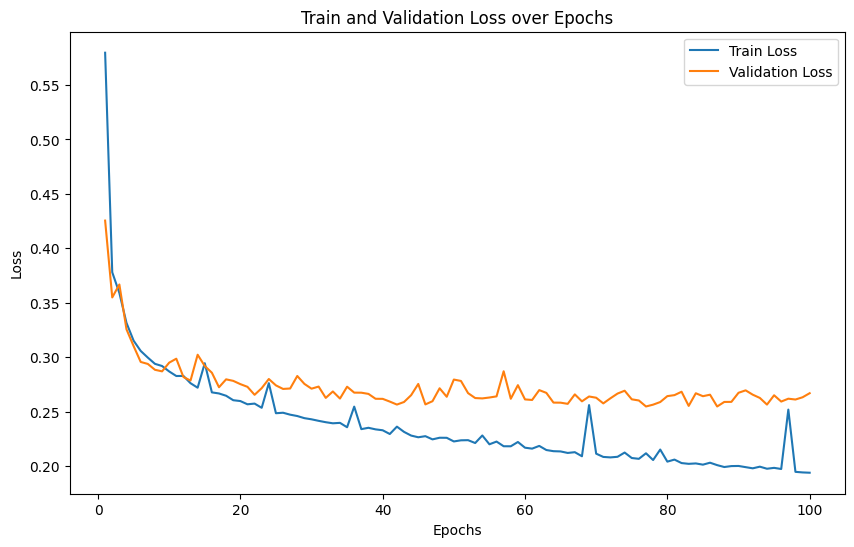

In [ ]:
# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

Оценка работы нашей модели

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import numpy as np

model.eval()
predictions = []
targets = []

with torch.no_grad():
    for features, prices in test_loader:
        outputs = model(features)
        predictions.append(outputs.numpy())
        targets.append(prices.numpy())

predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

mse = mean_squared_error(targets, predictions)
print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")

print("\nПримеры предсказанных и настоящих значений:")
for i in range(30):
    print(f"Predicted: {predictions[i][0]:.2f}, Actual: {targets[i][0]:.2f}")


Среднеквадратичная ошибка (MSE): 0.2671

Примеры предсказанных и настоящих значений:
Predicted: 0.45, Actual: 0.48
Predicted: 1.28, Actual: 0.46
Predicted: 5.26, Actual: 5.00
Predicted: 2.73, Actual: 2.19
Predicted: 2.58, Actual: 2.78
Predicted: 1.68, Actual: 1.59
Predicted: 2.16, Actual: 1.98
Predicted: 1.63, Actual: 1.58
Predicted: 2.68, Actual: 3.40
Predicted: 4.88, Actual: 4.47
Predicted: 1.08, Actual: 1.23
Predicted: 2.22, Actual: 2.54
Predicted: 1.63, Actual: 2.15
Predicted: 2.22, Actual: 2.20
Predicted: 2.69, Actual: 2.20
Predicted: 1.65, Actual: 1.36
Predicted: 1.97, Actual: 1.78
Predicted: 1.45, Actual: 1.88
Predicted: 1.67, Actual: 1.40
Predicted: 1.10, Actual: 1.38
Predicted: 4.30, Actual: 4.25
Predicted: 3.51, Actual: 4.06
Predicted: 1.31, Actual: 1.39
Predicted: 4.09, Actual: 5.00
Predicted: 1.83, Actual: 1.62
Predicted: 0.50, Actual: 0.51
Predicted: 2.07, Actual: 1.51
Predicted: 0.98, Actual: 0.95
Predicted: 1.82, Actual: 2.04
Predicted: 3.91, Actual: 3.62


# **Задание**
Для классификации цифры по изображению вам необхоимо
1. Доставить недостающие элементы в dataloader
2. Написать свою модель нейронной сети(она на вход принимает изображение с размером с входным слоем 784 и на выходе должна иметь 10 значений )
   
        Заметьте: Необходимо из фото- 2D (28x28) преобразовать в одномерный массив в 1D (784)
        для этого можно использовать вот эту запись
        x = x.view(-1, 28*28)  # Размер батча x 784
3.  Определяем функцию потерь и оптимизатор
        Заметьте: Функцию потерь для задачи классификации
4.  Выбрать количество оптимальных эпох для обучения
5. Обучить модель и сделать выводы



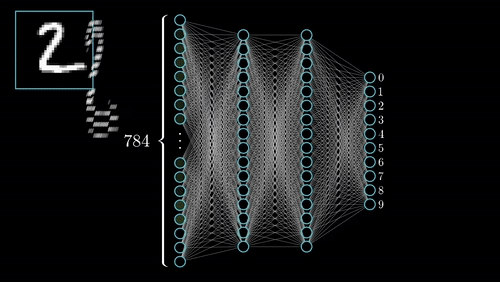

# **Импортирование необходимых библиотек**

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# **Чтение тренировочной и тестовой выборки**

In [ ]:
# Подготовка данных
transform = transforms.Compose([
    transforms.ToTensor(),                # Преобразуем в тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормализуем данные
])

# Загружаем тренировочный и тестовый наборы данных
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Using downloaded and verified file: ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.0MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.15MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Отобразим загруженные фотографии

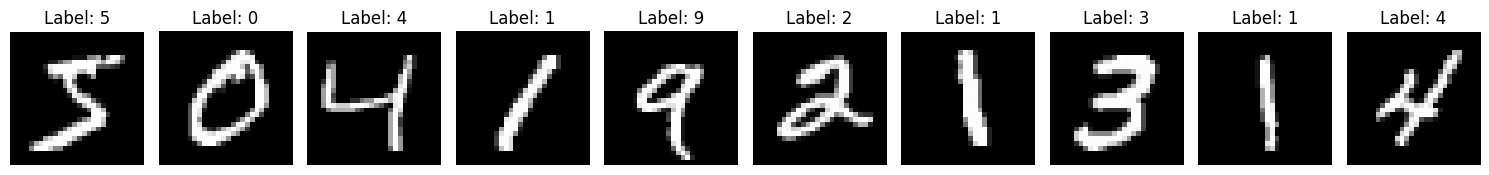

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(15, 3))

for idx in range(10):
    img, label = train_dataset[idx]
    img = img.squeeze().numpy()

    ax = axes[idx]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {label}')

plt.tight_layout()
plt.show()

# **Создание Pytorch DataLoader'a**

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=, shuffle=False)

# **Создание Pytorch модели многослойного перцептрона**

In [ ]:
class DigitClassifier(nn.Module):
    def __init__(self):


    def forward(self, x):
        x = x.view(-1, 28*28)
        return x

# Создаем экземпляр модели
model =

# Выводим структуру модели
print(model)

DigitClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


# **Выбор функции потерь и оптимизатора градиентного спуска**

In [ ]:
# Определяем функцию потерь и оптимизатор
criterion =
optimizer =

# **Обучение модели по эпохам**

In [ ]:
# Списки для хранения потерь
train_losses = []
val_losses = []

# Обучение
epochs = ???

for epoch in range(epochs):
  ???
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Epoch 1/10, Train Loss: 0.0134, Validation Loss: 0.1308
Epoch 2/10, Train Loss: 0.0159, Validation Loss: 0.1626
Epoch 3/10, Train Loss: 0.0095, Validation Loss: 0.1610
Epoch 4/10, Train Loss: 0.0145, Validation Loss: 0.1544
Epoch 5/10, Train Loss: 0.0127, Validation Loss: 0.1651
Epoch 6/10, Train Loss: 0.0124, Validation Loss: 0.1500
Epoch 7/10, Train Loss: 0.0151, Validation Loss: 0.1590
Epoch 8/10, Train Loss: 0.0087, Validation Loss: 0.1557
Epoch 9/10, Train Loss: 0.0129, Validation Loss: 0.1575
Epoch 10/10, Train Loss: 0.0145, Validation Loss: 0.2312


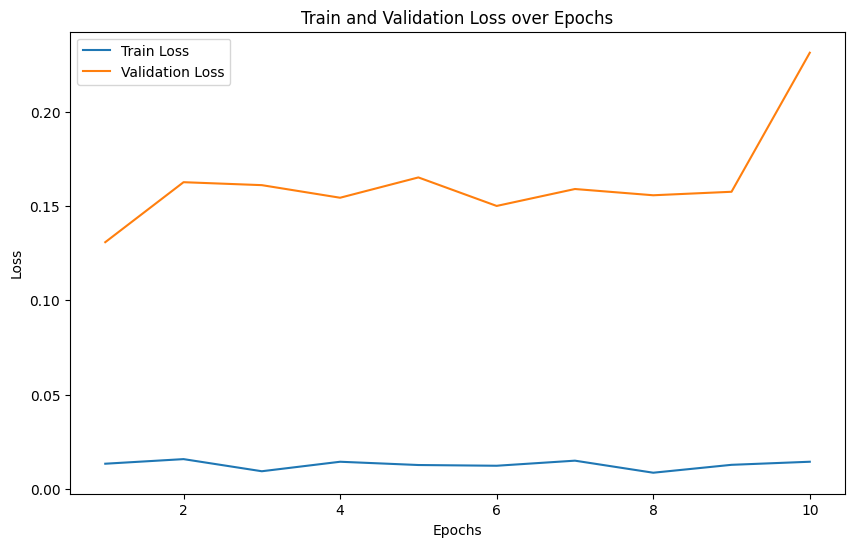

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

# **Проверка качества модели по классам на обучающей и тестовой выборках**

In [ ]:
correct = 0
total = 0

with torch.no_grad():  # Отключаем вычисление градиентов
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Выбираем класс с наибольшей вероятностью
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 97.14%


# **Визуализация наших графиков**

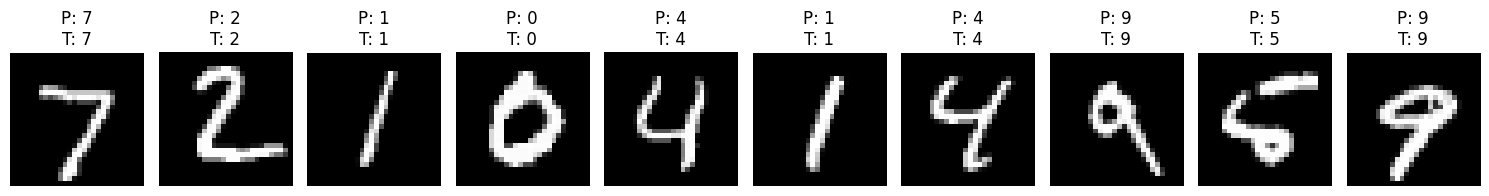

In [ ]:
# Получаем первую batch из тестового набора
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Переключаем модель в режим оценки
model.eval()
with torch.no_grad():
    outputs = model(images)
    # Получаем предсказанные метки
    _, predicted = torch.max(outputs, 1)

images = images[:10]
labels = labels[:10]
predicted = predicted[:10]

# Визуализация
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for idx in range(10):
    img = images[idx].squeeze().numpy()
    ax = axes[idx]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'P: {predicted[idx].item()}\nT: {labels[idx].item()}')

plt.tight_layout()
plt.show()

# Комментарии к самостоятельной работе
- Изменение скорости обучения и размера батча делаем только после нахождения момента переобучения - эпохи где ошибка на тестовой выборке самая маленькая. Иначе улучшением шагов вы можете усилить переобучение (улучшаться при обучении, ухудшаться для теста).

- увеличение размера батча при том же числе итераций должно хоть немного (в среднем) улучшить обучение. Потому что мы делаем такое же количество, но более хороших шагов. Это может не сходится с опытом по разным причинам, но из теории мы ожидаем какое-то улучшение

- Во сколько раз меняете скорость обучения или размер батча - во столько же меняете количество эпох для сохранения итераций. На практике это условие не нужно, потому что при новом обучении меняют сразу много гиперпараметров. Но мы учимся, поэтому исследуем поведение каждого гиперпараметра отдельно: мы не можем сравнить 5 больших шагов и 7 маленьких, можем сравнить 5 больших и 5 маленьких.

- При изменении модели нужно искать гиперпараметры заново - это новая модель. Не нужно расписывать снова все шаги, просто сделайте это сами - найдите переобучение и поищите скорость и размер батча, которые будут лучше.